<a id="2"></a>
# Modeling the Results of Pulls for UR Shards Using Monte Carlo Simulations
Credit to **VoidTwo** (_voidtwo on Discord_) for writing the code<br>
Report written by Nillabutt<br>
February 8, 2024

[*jump to the tables*](#1)

In [1]:
# Future imports
from __future__ import annotations

# Standard imports
from collections import defaultdict
from multiprocessing.pool import Pool as mp_Pool
from secrets import randbelow as secrets_randbelow
from typing import TYPE_CHECKING

# 3rd party imports
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

In [2]:
# Type checking
if TYPE_CHECKING:
    from typing import (
        ClassVar,
        Final)

    from matplotlib.axes import Axes

In [3]:
class SummonInfo:
    shard_probability_range: ClassVar[int] = 100_000
    shard_probability_threshold: ClassVar[dict[int, int]] = {
        1: 18_000,  # 18.000%
        2: 23_500,  # 5.500%
        5: 25_500}  # 2.000%
    shard_probability_order: ClassVar[tuple[int, ...]] = (
        1, 2, 5)

    shard_pities: ClassVar[dict[int, int]] = {
        1: 6,
        2: 16,
        5: 65}
    shard_pity_floors: ClassVar[dict[int, int]] = {
        1: 6,
        2: 15,
        5: 58}
    shard_pity_priority: ClassVar[tuple[int, ...]] = (
        5, 2, 1)

    shard_goal: ClassVar[int] = 260

    __slots__: tuple[str, ...] = ()

    def __init__(self) -> None:
        return


class SummonProgress:
    __slots__: tuple[str, ...] = (
        '__pity_counts',
        '__accumulated_shards')

    def __init__(self) -> None:
        shard_count: int
        self.__pity_counts: Final[dict[int, int]] = dict(
            (shard_count, 1) for shard_count in SummonInfo.shard_pity_priority)
        self.__accumulated_shards: int = 0
        return

    def __str__(self) -> str:
        return (
            f'__pity_counts: {self.__pity_counts}\n'
            f'__accumulated_shards: {self.__accumulated_shards}')

    @property
    def accumulated_shards(self) -> int:
        return self.__accumulated_shards

    def add_shards(self, shard_count: int) -> None:
        self.__accumulated_shards += shard_count
        return

    def get_pity_count(self, shard_count: int) -> int:
        return self.__pity_counts[shard_count]

    def add_pity(self, shard_count: int) -> None:
        self.__pity_counts[shard_count] += 1
        return

    def reset_pity(self, shard_count: int) -> None:
        self.__pity_counts[shard_count] = 1
        return

In [4]:
def simulate_summon(summon_progress: SummonProgress) -> None:
    add_shards: int = 0
    shard_count: int

    for shard_count in SummonInfo.shard_pity_priority:
        if summon_progress.get_pity_count(shard_count) >= SummonInfo.shard_pities[shard_count]:
            summon_progress.reset_pity(shard_count)
            add_shards = shard_count
            break

    if add_shards == 0:
        random_value: int = secrets_randbelow(SummonInfo.shard_probability_range)
        threshold_expired: bool = False

        for shard_count in SummonInfo.shard_probability_order:
            if add_shards == 0 \
                    and not threshold_expired \
                    and random_value < SummonInfo.shard_probability_threshold[shard_count]:
                threshold_expired = True

                if summon_progress.get_pity_count(shard_count) >= SummonInfo.shard_pity_floors[shard_count]:
                    summon_progress.reset_pity(shard_count)
                    add_shards = shard_count
                    continue

            summon_progress.add_pity(shard_count)
    else:
        for shard_count in SummonInfo.shard_pity_priority:
            if shard_count != add_shards:
                summon_progress.add_pity(shard_count)

    summon_progress.add_shards(add_shards)
    return

In [5]:
def fully_summon(_: int) -> int:
    summon_progress: SummonProgress = SummonProgress()
    summon_count: int = 0

    while summon_progress.accumulated_shards < SummonInfo.shard_goal:
        simulate_summon(summon_progress)
        summon_count += 1
        # print(f'Summon #{summon_count}: {summon_progress.accumulated_shards}')
    return summon_count

In [6]:
def blues(target) -> None:
    SummonInfo.shard_goal = target
    iterations: Final[int] = 20000
    results: defaultdict = defaultdict(int)
    pool: mp_Pool
    summon_count: int

    for summon_count in map(fully_summon, range(iterations)):
        results[summon_count] += 1

    result_summon_counts: list[int] = []
    result_summon_count_counts: list[int] = []
    summon_count_count: int

    for summon_count, summon_count_count in sorted(results.items()):
        result_summon_counts.append(summon_count)
        result_summon_count_counts.append(summon_count_count)
    
    cmap = plt.get_cmap('cool')
    
    results_df: DataFrame = pd.DataFrame({'Blue Scrolls': result_summon_counts, 'Likelihood': result_summon_count_counts})
    color_length = len(results_df['Blue Scrolls'])
    result_ax: Axes = results_df.plot.bar(x='Blue Scrolls', y='Likelihood', legend=None, color=cmap(np.linspace(0.1,0.9,color_length)))
    
    plt.title(f"Probability Distribution of Pulls for {target} UR Shards")
    plt.show()
    print(results_df)
    blue_max = results_df["Blue Scrolls"].max()
    blue_min = results_df["Blue Scrolls"].min()
    results_df["Weighted"] = results_df["Likelihood"] * results_df["Blue Scrolls"]
    average_blues = results_df["Weighted"].sum() / iterations
    blue_freq_max = results_df["Likelihood"].max()
    blue_mode = results_df.loc[results_df["Likelihood"] == blue_freq_max, "Blue Scrolls"].iloc[0]
    print(F"Iterations: {iterations}")
    print(f"Min:  {blue_min} blues")
    print(f"Max:  {blue_max} blues")
    print(f"Mean: {average_blues} blues")
    print(f"Mode: {blue_mode} blues")
    return

<a id="1"></a>
# Running the Simulations (20,000 iterations)

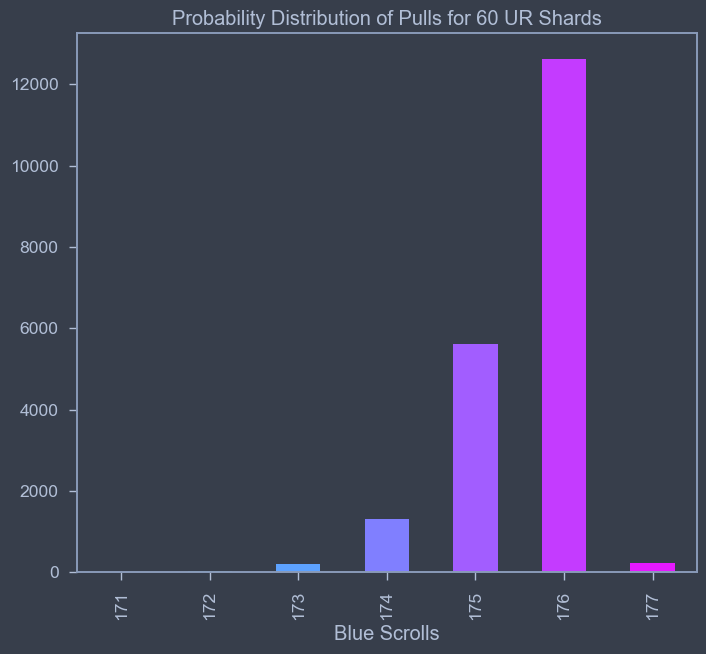

   Blue Scrolls  Likelihood
0           171           1
1           172          18
2           173         202
3           174        1295
4           175        5620
5           176       12627
6           177         237
Iterations: 20000
Min:  171 blues
Max:  177 blues
Mean: 175.5672 blues
Mode: 176 blues


In [7]:
# Blues for 60 shards (0 star)
blues(60)

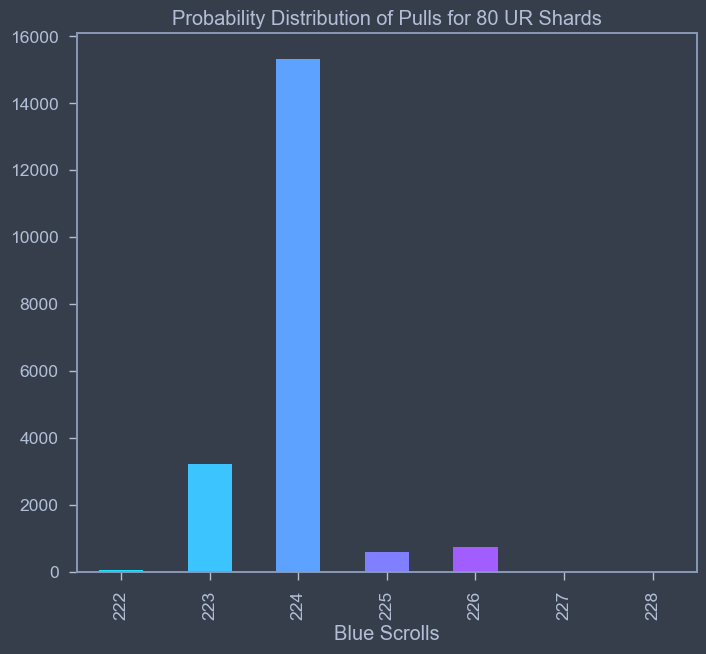

   Blue Scrolls  Likelihood
0           222          78
1           223        3220
2           224       15329
3           225         608
4           226         752
5           227          11
6           228           2
Iterations: 20000
Min:  222 blues
Max:  228 blues
Mean: 223.93885 blues
Mode: 224 blues


In [8]:
# Blues for 80 shards (1 star)
blues(80)

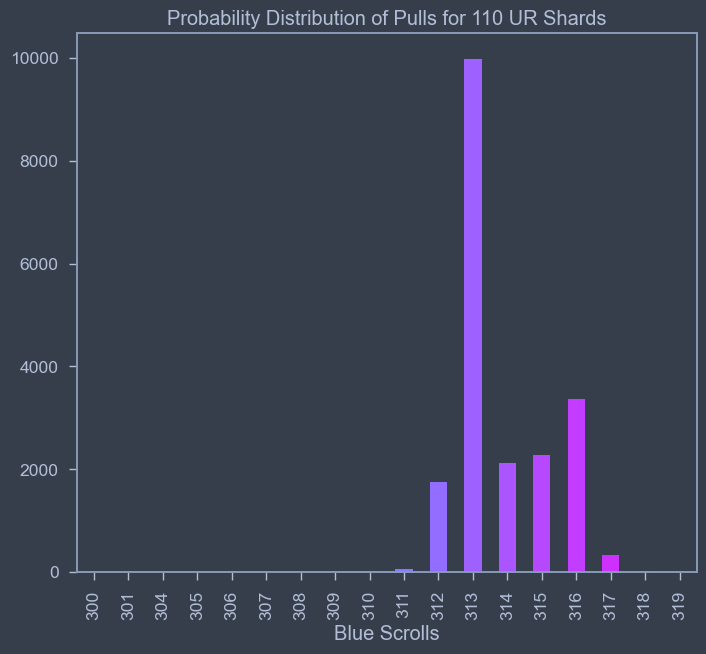

    Blue Scrolls  Likelihood
0            300           2
1            301           1
2            304           1
3            305           2
4            306           8
5            307          10
6            308          10
7            309          11
8            310          22
9            311          57
10           312        1757
11           313        9985
12           314        2123
13           315        2283
14           316        3362
15           317         335
16           318          22
17           319           9
Iterations: 20000
Min:  300 blues
Max:  319 blues
Mean: 313.80345 blues
Mode: 313 blues


In [9]:
# Blues for 110 shards (2 star)
blues(110)

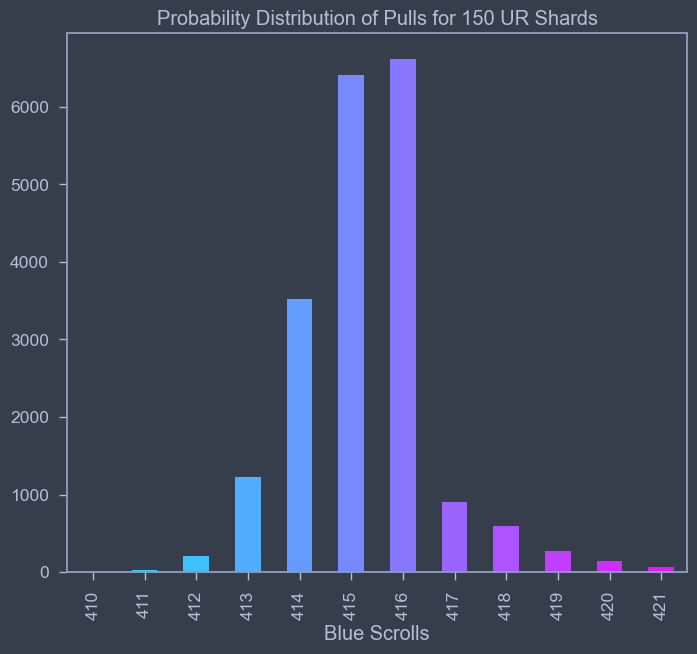

    Blue Scrolls  Likelihood
0            410           3
1            411          30
2            412         209
3            413        1224
4            414        3527
5            415        6410
6            416        6618
7            417         901
8            418         597
9            419         268
10           420         144
11           421          69
Iterations: 20000
Min:  410 blues
Max:  421 blues
Mean: 415.284 blues
Mode: 416 blues


In [10]:
# Blues for 150 shards (3 star)
blues(150)

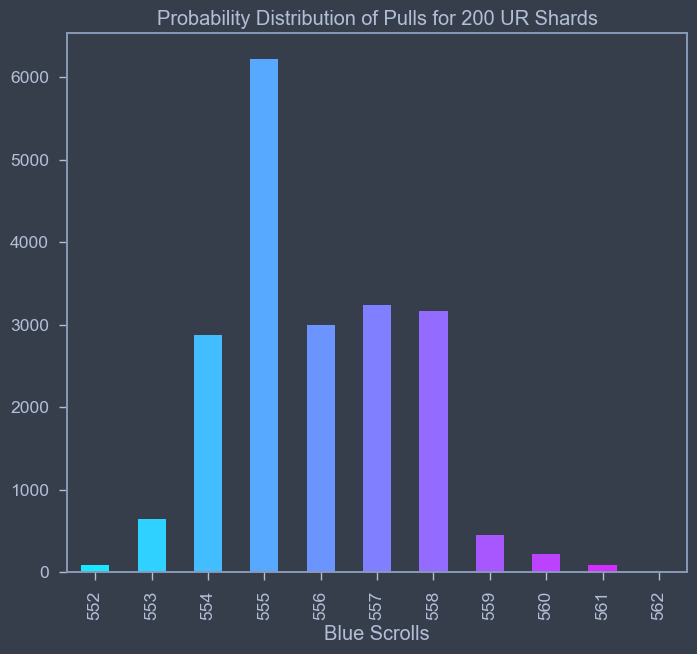

    Blue Scrolls  Likelihood
0            552          81
1            553         649
2            554        2873
3            555        6222
4            556        2995
5            557        3242
6            558        3167
7            559         451
8            560         216
9            561          92
10           562          12
Iterations: 20000
Min:  552 blues
Max:  562 blues
Mean: 555.9043 blues
Mode: 555 blues


In [11]:
# Blues for 200 shards (4 star)
blues(200)

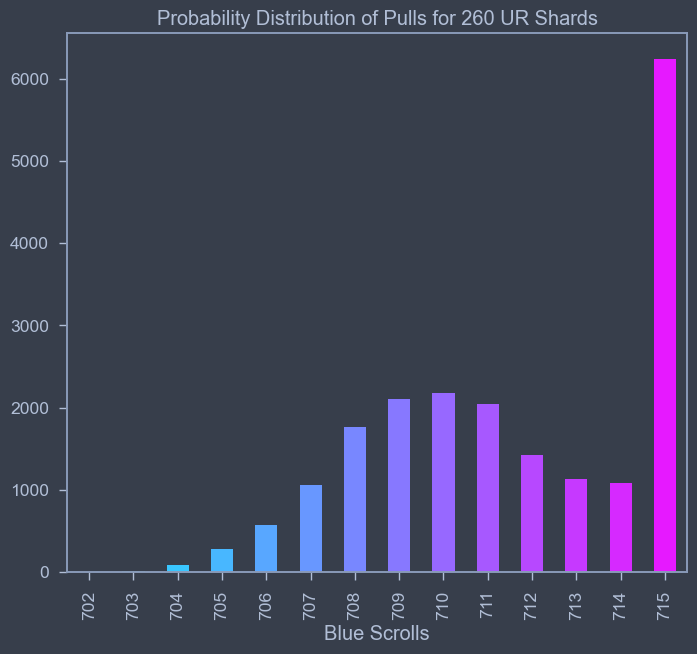

    Blue Scrolls  Likelihood
0            702           1
1            703           9
2            704          84
3            705         284
4            706         579
5            707        1065
6            708        1767
7            709        2111
8            710        2178
9            711        2041
10           712        1421
11           713        1135
12           714        1084
13           715        6241
Iterations: 20000
Min:  702 blues
Max:  715 blues
Mean: 711.5339 blues
Mode: 715 blues


In [12]:
# Blues for 260 shards (5 star)
blues(260)

[*Back to Top*](#2)